# Clouds

##### A GWDST project to analyze and visualize modeled cloud features, particularly variability and extremes.

In [1]:
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk', palette='colorblind')

In [2]:
ds = xr.open_mfdataset('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-07-*.nc')
ds = ds.sel(lat=slice(-20,20))
ds

<xarray.Dataset>
Dimensions:          (ilev: 71, lat: 42, lev: 70, lon: 288, nbnd: 2, time: 744)
Coordinates:
  * lat              (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev              (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 ...
  * ilev             (ilev) float64 4.5e-06 7.42e-06 1.223e-05 2.017e-05 ...
  * time             (time) datetime64[ns] 2002-07-01 2002-07-01T00:59:59 ...
Dimensions without coordinates: nbnd
Data variables:
    gw               (time, lat) float64 0.01552 0.01561 0.01569 0.01577 ...
    hyam             (time, lev) float64 5.96e-09 9.827e-09 1.62e-08 ...
    hybm             (time, lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0               (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    hyai             (time, ilev) float64 4.5e-09 7.42e-09 1.223e-08 ...
    hybi             (time, ilev) float64 0.0 0.0 0.0 0.0 0.0 0.

In [10]:
pconvt = 7000 * np.log(ds.PS / ds.PCONVT)    # Converting from pressure to height estimate

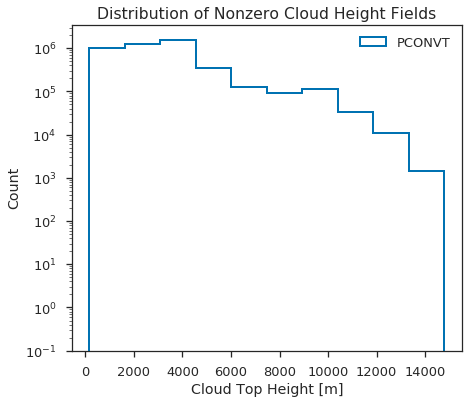

In [18]:
with sns.axes_style('ticks'):
    f, ax = plt.subplots(figsize=(7,6))
    pconvt.where(pconvt > 0).plot.hist(ax=ax, log=True, histtype='step', linewidth=2, label='PCONVT')
    
    ax.legend()
    ax.set_title('Distribution of Nonzero Cloud Height Fields')
    ax.set_xlabel('Cloud Top Height [m]')
    
    f.savefig('../figures/clouds/hght_dist.png')

### Will return to this attempt to subset CLOUDFRAC_CLUBB

In [42]:
cfc = xr.open_dataarray('/glade/scratch/mcamron/output/f.c54120.FWscHIST.f09_f09.gwdst/cloudfrac_clubb.nc')
test = cfc.stack(z=('lat', 'lon', 'time'))

In [45]:
print(np.shape( test > 0 ), np.shape(np.where( test > 0)))

(70, 8999424) (2, 50332190)
